<a href="https://colab.research.google.com/github/JamieHeffo/Article-17-Environmental-Analysis/blob/main/EA_C20483462.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How has Article 17 of the European Union affected Irish protected species and their Natural Habitats

The European Union Habitat's Directive or Article 17, plays a crucual role in safeguarding our planets natural order. It ensures that habitat's and species across Europe are protected for future generations.

Article 17 is a part of the EU Habitat Directive that defines a set of rules for countries in the European Union to follow designed to help nature thrive. Ensuring that countries take care of their natural areas and the animals and plants that call them home. One important aspeect of article 17 is to check how well these countries look after their natural ecosystems

To understand how well Article 17 is working for Irish Ecosystems, we can look at what has happened between 2012 and 2019. Have natural areas grown or shrunk? Have forests expanded or dissapear. By comparing Ireland and two points in time we can paint a clear picture of how well Artice 17 is paying off for our natural areas.

In [ ]:
# Import neccessary libraries
import geopandas as gpd
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Import data
base_path = '/content/drive/MyDrive/EA Data'
ireland_map = gpd.read_file('/content/drive/MyDrive/EA Data/IrelandMap.geojson')

# Store our shapefiles
shapefile_cache = {}

# Create GeoDataFrame from Data
Next we can load and combine all the shapefiles from our drive and create a single GeoDataFrame from it.

We adjust any coordinate referencing systems if required and cache the combined GeoDataFrame for future use to eliminate the need to load from the drive

In [ ]:
def load_and_combine_shapefiles(data_path, target_crs='EPSG:4326'):

    # If we've already loaded the data, return
    if data_path in shapefile_cache:
        return shapefile_cache[data_path]

    combined_shapes = []

    # Iterate through data folder for shapefiles
    for filename in os.listdir(data_path):

        # If its a shapefile
        if filename.endswith('.shp'):# and 'FRR' in filename:
            file_path = os.path.join(data_path, filename)

            # Create GeoDataFrame from the Shapefile
            shape = gpd.read_file(file_path)
            #print(f"Columns in {filename}: {shape.columns.tolist()}")

            # Convert CRS if different from target CRS
            if shape.crs != target_crs:
                shape = shape.to_crs(target_crs)

            # Add the shapefile to the list
            combined_shapes.append(shape)

    # Combine all shapefiles into one GeoDatFrame
    if combined_shapes:
        all_shapes_concatenated = pd.concat(combined_shapes, ignore_index=True)

        #Ensure that each GeoDataFrame has geometry
        if 'geometry' in all_shapes_concatenated.columns:
            combined_geo = gpd.GeoDataFrame(all_shapes_concatenated, geometry='geometry', crs=target_crs)
        else:
            # If no geometry column exists, create an empty GeoDataFrame with a placeholder geometry column
            combined_geo = gpd.GeoDataFrame(columns=['geometry'], crs=target_crs)
    else:
        # Return an empty GeoDataFrame with a placeholder geometry column if no shapes were loaded
        combined_geo = gpd.GeoDataFrame(columns=['geometry'], crs=target_crs)

    # Cache the loaded and combined GeoDataFrame and return
    shapefile_cache[data_path] = combined_geo
    return combined_geo

# Filter out any other types of geometries and convert multipolygons to polygons by exploding them

In [ ]:
# Some years contain different types of data, we only want Polygons
def preprocess_geometries(shapes_df):
    if 'geometry' in shapes_df:
        # Filter out multipolygons
        valid_polygons = shapes_df[shapes_df.geometry.type.isin(['Polygon', 'MultiPolygon'])]

        # Convert multipolygons to polygons and maintain the current index behavior
        valid_polygons = valid_polygons.explode(index_parts=True).reset_index(drop=True)
        return valid_polygons

    return shapes_df

# Allow user to compare habitat changes between 2012 and 2019


In [ ]:
def interactive_habitat_comparison(base_path, year1, year2, base_map, habitat_type):

    # Paths to the files
    year1_path = os.path.join(base_path, str(year1), 'Habitats', habitat_type)
    year2_path = os.path.join(base_path, str(year2), 'Habitats', habitat_type)

    # Gather unique habitat names
    habitat_names = set(os.listdir(year1_path)) | set(os.listdir(year2_path))
    print(f"Select a {habitat_type} to plot (or select '0' for all {habitat_type}):")
    print("0. All Habitats")
    for i, name in enumerate(sorted(habitat_names), 1):
        print(f"{i}. {name}")

    # Take User Input for which habitat to analyze
    try:
        selection = int(input("Enter your choice: "))
        habitat_list = sorted(habitat_names)
        if selection < 0 or selection > len(habitat_list):
            raise ValueError("Selection out of range")

        # Store the selected choice
        selected_name = habitat_list[selection - 1] if selection > 0 else "All {habitat_type}"

        # Load and combine the habitats
        if selection == 0:
            # Process all habitats from both years
            all_habitats_2012 = [load_and_combine_shapefiles(os.path.join(year1_path, fn)) for fn in os.listdir(year1_path)]
            all_habitats_2019 = [load_and_combine_shapefiles(os.path.join(year2_path, fn)) for fn in os.listdir(year2_path)]
            shapes_2012 = gpd.GeoDataFrame(pd.concat(all_habitats_2012, ignore_index=True), crs='EPSG:4326')
            shapes_2019 = gpd.GeoDataFrame(pd.concat(all_habitats_2019, ignore_index=True), crs='EPSG:4326')
        else:
            # Process selected habitat from both years
            name = habitat_list[selection - 1]
            path_1 = os.path.join(year1_path, name)
            path_2 = os.path.join(year2_path, name)
            shapes_2012 = load_and_combine_shapefiles(path_1)
            shapes_2019 = load_and_combine_shapefiles(path_2)

        # Preprocess data to ensure consistency
        shapes_2012 = preprocess_geometries(shapes_2012)
        shapes_2019 = preprocess_geometries(shapes_2019)

        # Calculate the areas lost between 2019 and 2012
        lost_areas = gpd.overlay(shapes_2012, shapes_2019, how='difference')
        gained_areas = gpd.overlay(shapes_2019, shapes_2012, how='difference')

        # Plot this on the map
        plot_habitat_changes(shapes_2012, shapes_2019, lost_areas, gained_areas, base_map, year1, year2, habitat_type, selected_name)

    # Uh oh
    except ValueError as e:
        print(f"Invalid input: {e}")

# Plotting Maps



*   filter out non-finite geometries
*   Plot the base map of Ireland
*   Plot the 2012 and 2019 data chosen by the user
*   Create a legend of this data
*   Create bar chart from the area comparison

In [ ]:
def plot_habitat_changes(shapes_2012, shapes_2019, lost_areas, gained_areas, base_map, year1, year2, habitat_type, selected_name):

    # Directly modify each GeoDataFrame to filter out non-finite geometries
    shapes_2012 = shapes_2012[shapes_2012.geometry.bounds.apply(lambda x: np.isfinite(x).all(), axis=1)]
    shapes_2019 = shapes_2019[shapes_2019.geometry.bounds.apply(lambda x: np.isfinite(x).all(), axis=1)]
    lost_areas = lost_areas[lost_areas.geometry.bounds.apply(lambda x: np.isfinite(x).all(), axis=1)]
    gained_areas = gained_areas[gained_areas.geometry.bounds.apply(lambda x: np.isfinite(x).all(), axis=1)]

    # Plot the Ireland base map
    fig, axs = plt.subplots(1, 3, figsize=(30, 10), subplot_kw={'aspect': 'auto'})
    base_map.plot(color='green', edgecolor='darkgreen', ax=axs[0])
    base_map.plot(color='green', edgecolor='darkgreen', ax=axs[1])
    base_map.plot(color='green', edgecolor='darkgreen', ax=axs[2])

    # Plot each of the polygons on the Ireland map
    shapes_2012.plot(ax=axs[0], color='orange', alpha=0.7, label=f'{habitat_type} 2012')
    shapes_2019.plot(ax=axs[1], color='blue', alpha=0.7, label=f'{habitat_type} 2019')
    lost_areas.plot(ax=axs[2], color='red', alpha=0.7, label='Lost Areas')
    gained_areas.plot(ax=axs[2], color='plum', alpha=0.7, label='Gained Areas')

    # Set the titles for each of the maps
    axs[0].set_title(f"{selected_name} in {year1}")
    axs[1].set_title(f"{selected_name} in {year2}")
    axs[2].set_title(f"Changes in {selected_name}")

    # Turn off the axis markings in each diagram
    for ax in axs:
        ax.axis('off')

    # Plot the Legend
    legend_elements = [
        Patch(facecolor='orange', label=f'{habitat_type} 2012'),
        Patch(facecolor='blue', label=f'{habitat_type} 2019'),
        Patch(facecolor='red', label='Lost Areas'),
        Patch(facecolor='plum', label='Gained Areas')
    ]

    fig.legend(handles=legend_elements, loc='upper right', title="Legend")
    plt.tight_layout()
    plt.show()


    # Create a bar chart comparing the areas in 2012 and 2019
    try:
      if 'AREA' in shapes_2012.columns:
          areas_2012 = [shapes_2012['AREA'].sum()]
      else:
          # Default to 0
          print("2012 data missing")
          areas_2012 = [0]

      if 'AREA' in shapes_2019.columns:
          print("2012 data missing")
          areas_2019 = [shapes_2019['AREA'].sum()]
      else:
        # Default to 0
          areas_2019 = [0]

      # Names of the areas
      index = [str(year1), str(year2)]
      x = np.arange(len(index))
      bar_width = 2

      fig, ax = plt.subplots()
      rects1 = ax.bar(x - bar_width, areas_2012, bar_width, label=str(year1), color='orange')
      rects2 = ax.bar(x + bar_width, areas_2019, bar_width, label=str(year2), color='blue')

      ax.set_xlabel('Year')
      ax.set_ylabel('Total Area in Square Hectares')
      ax.set_title('Total Area Comparison')
      ax.set_xticks(x)
      ax.set_xticklabels(index)
      ax.legend()

      plt.show()

    except:
      print("Not enough data for comparison")

Plot Coastal Data

Select a Coastal to plot (or select '0' for all Coastal):
0. All Habitats
1. 1110_Sandbanks
2. 1130_Estuaries
3. 1140_Tidal_Mudflats_and_Sandflats
4. 1150_Coastal_Lagoons
5. 1160_Large_Shallow_Inlets_and_Bays
6. 1170_Reefs
7. 1180_Submarine_structures_made_by_leaking_gases
8. 1210_Annual_Vegetation_of_Drift_Lines
9. 1220_Perennial_Vegetation_of_Stony_Banks
10. 1230_Vegetated_Sea_Cliffs
11. 1310_Salicornia_mud
12. 1330_Atlantic_Salt_Meadows
13. 1410_Mediterranean_Salt_Meadows
14. 1420_Halophilous_Scrub
Enter your choice: 8


<ipython-input-4-1bc008d8d537>:44: UserWarning: `keep_geom_type=True` in overlay resulted in 12 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  lost_areas = gpd.overlay(shapes_2012, shapes_2019, how='difference')
<ipython-input-4-1bc008d8d537>:45: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  gained_areas = gpd.overlay(shapes_2019, shapes_2012, how='difference')


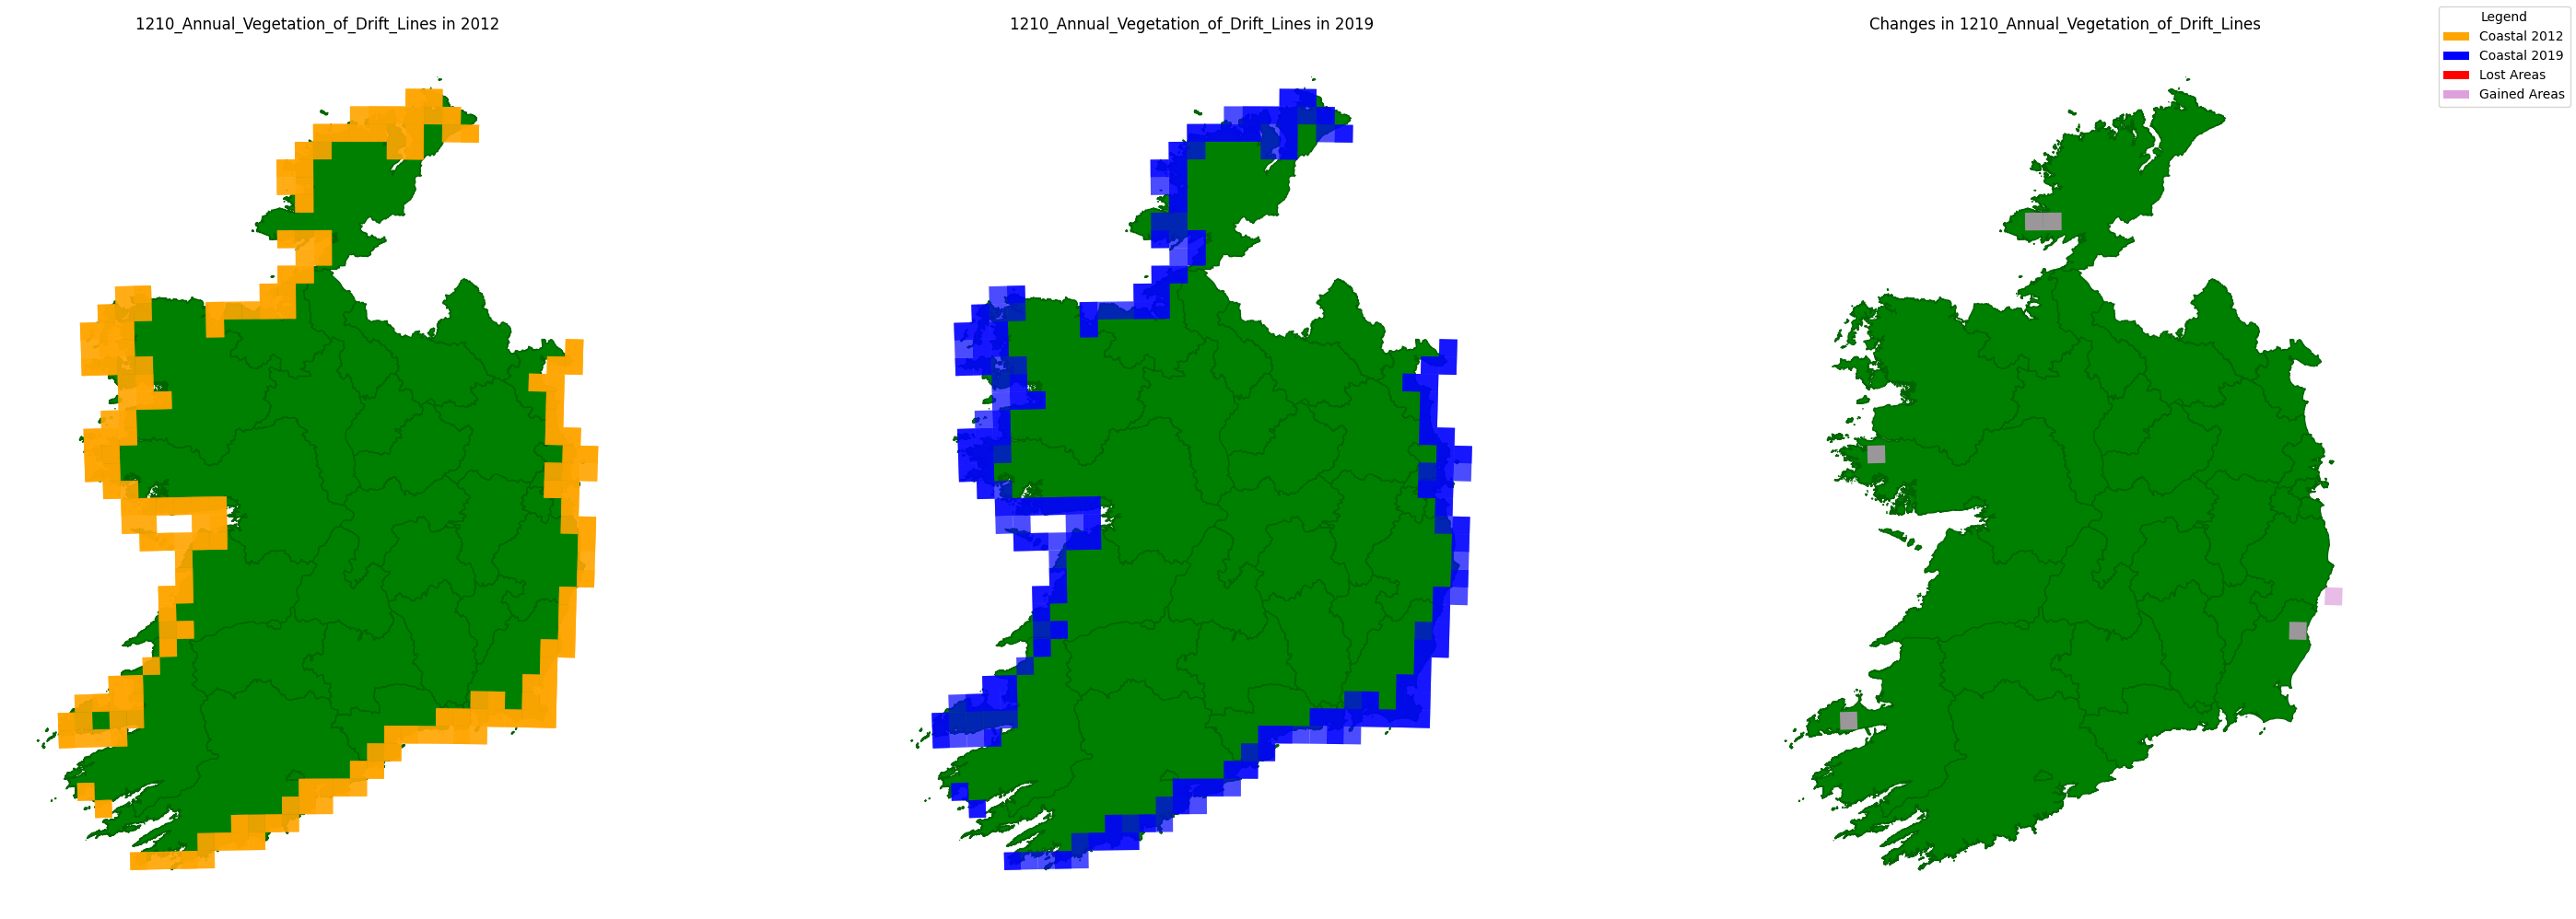

2012 data missing


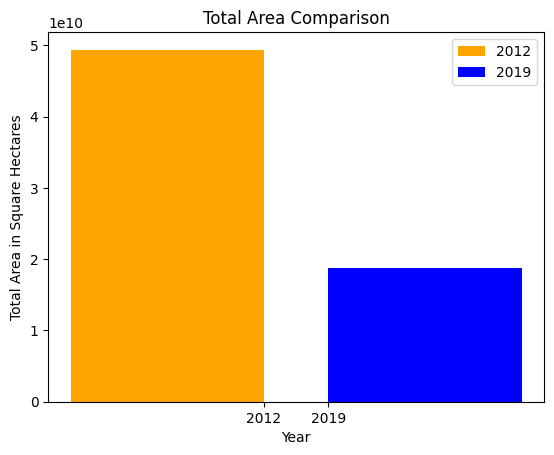

In [ ]:
interactive_habitat_comparison(base_path, 2012, 2019, ireland_map, 'Coastal')

# Plot Mammal Data

Select a Mammals to plot (or select '0' for all Mammals):
0. All Habitats
1. 1303_Lesser_horseshoe_bat_(Rhinolophus_hipposideros)
2. 1309_Common_pipistrelle_(Pipistrellus_pipistrellus)
3. 1314_Daubentons_bat_(Myotis_daubentoni)
4. 1317_Nathusius_pipistrelle_(Pipistrellus_nathusii)
5. 1322_Natterers_bat_(Myotis_nattereri)
6. 1326_Brown_long_eared_bat_(Plecotus_auritus)
7. 1330_Whiskered_bat_(Myotis_mystacinus)
8. 1331_Leislers_bat_(Nyctalus_leisleri)
9. 1334_Irish_hare_(Lepus_timidus)
10. Cetaceans_For_Publication
11. Raw Data
Enter your choice: 8


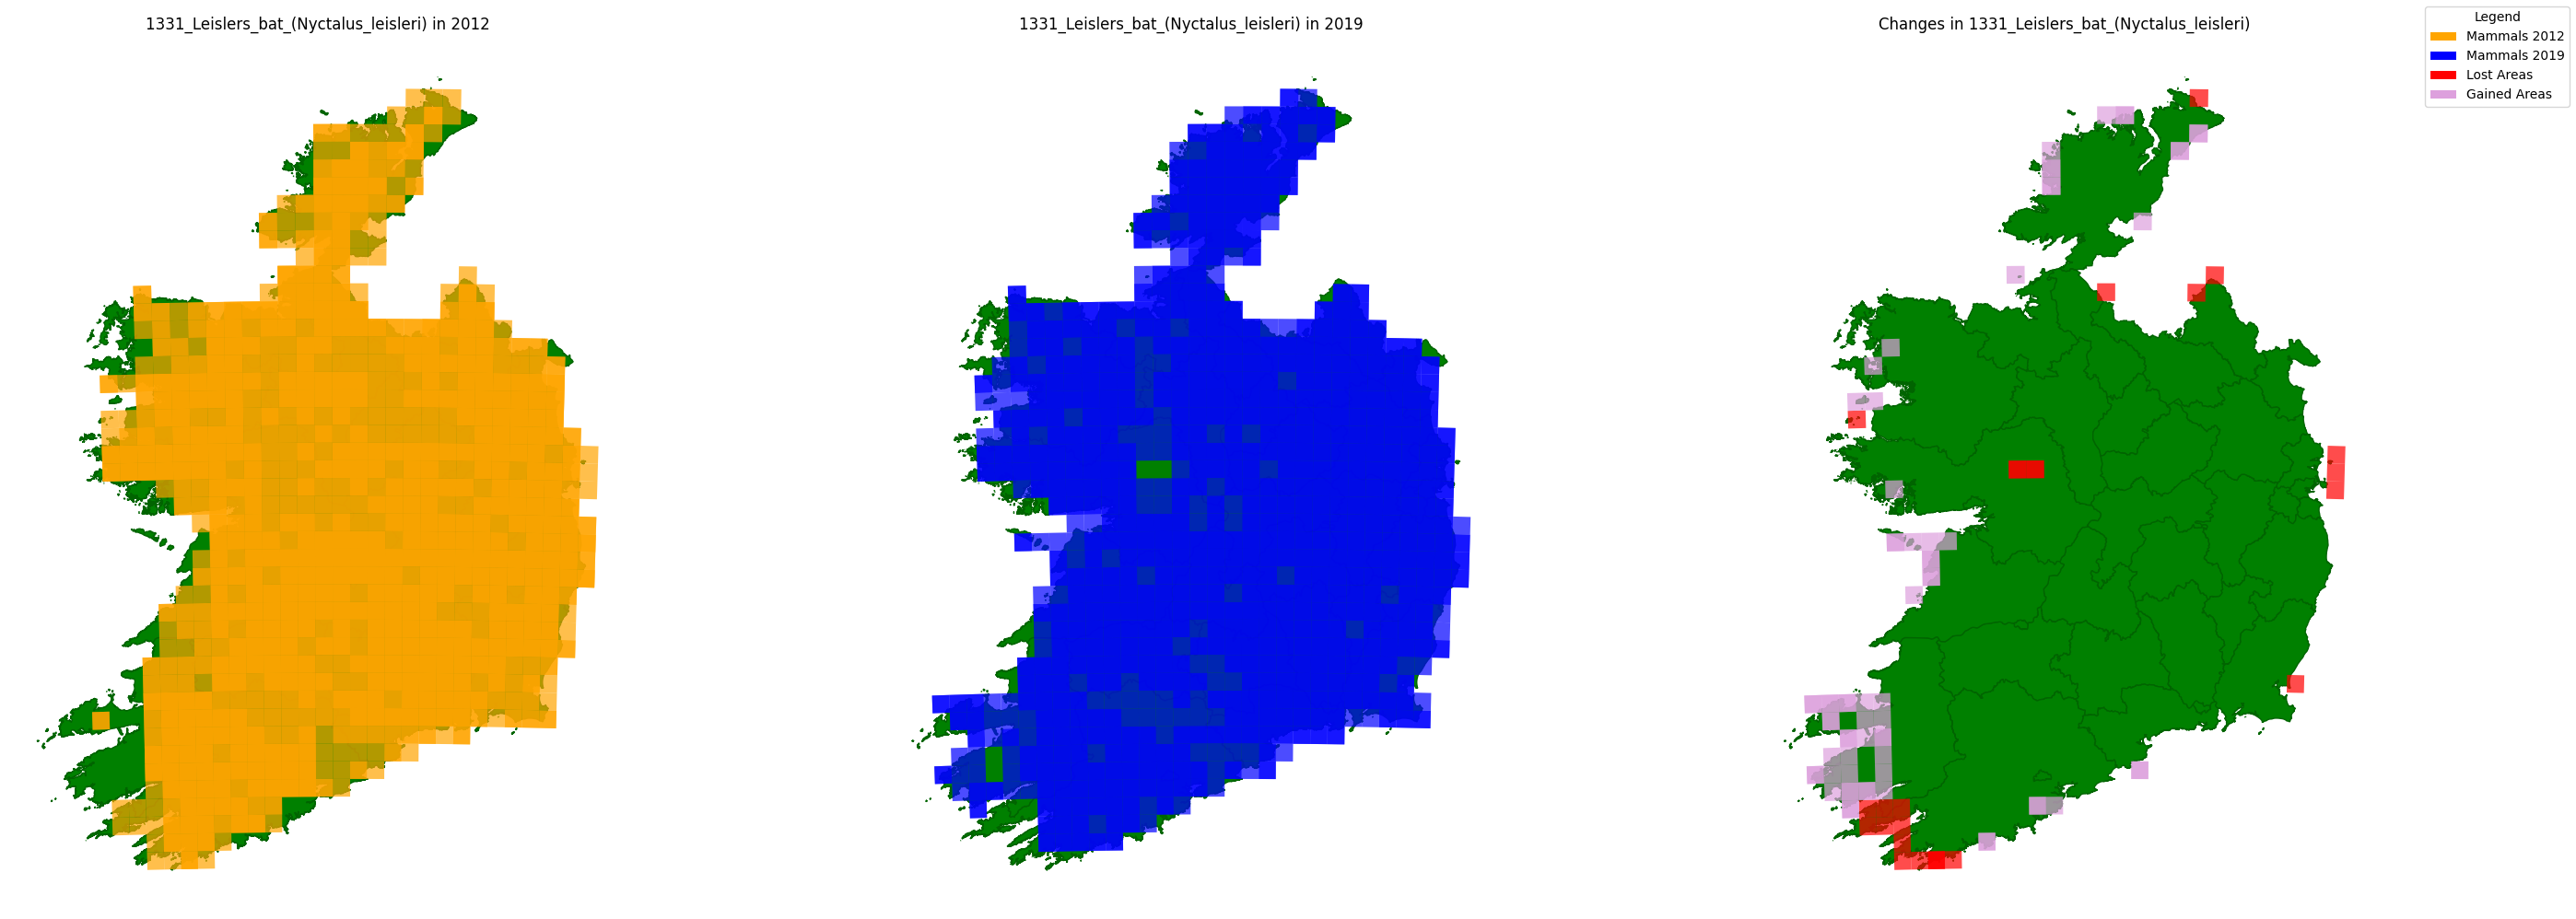

2012 data missing


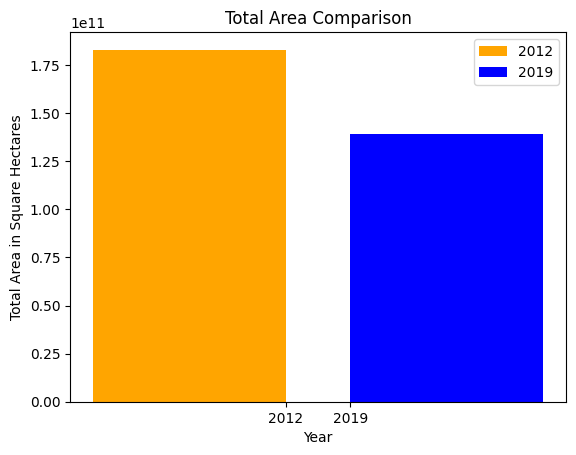

In [ ]:
interactive_habitat_comparison(base_path, 2012, 2019, ireland_map, 'Mammals')

# Plot Forestry Data

Select a Forests to plot (or select '0' for all Forests):
0. All Habitats
1. 91A0_Old_Oak_Woodlands
2. 91D0_Bog_Woodland
3. 91E0_Residual_Alluvial_Forests
4. 91J0_Yew_Woodlands
Enter your choice: 3


<ipython-input-4-1bc008d8d537>:44: UserWarning: `keep_geom_type=True` in overlay resulted in 40 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  lost_areas = gpd.overlay(shapes_2012, shapes_2019, how='difference')


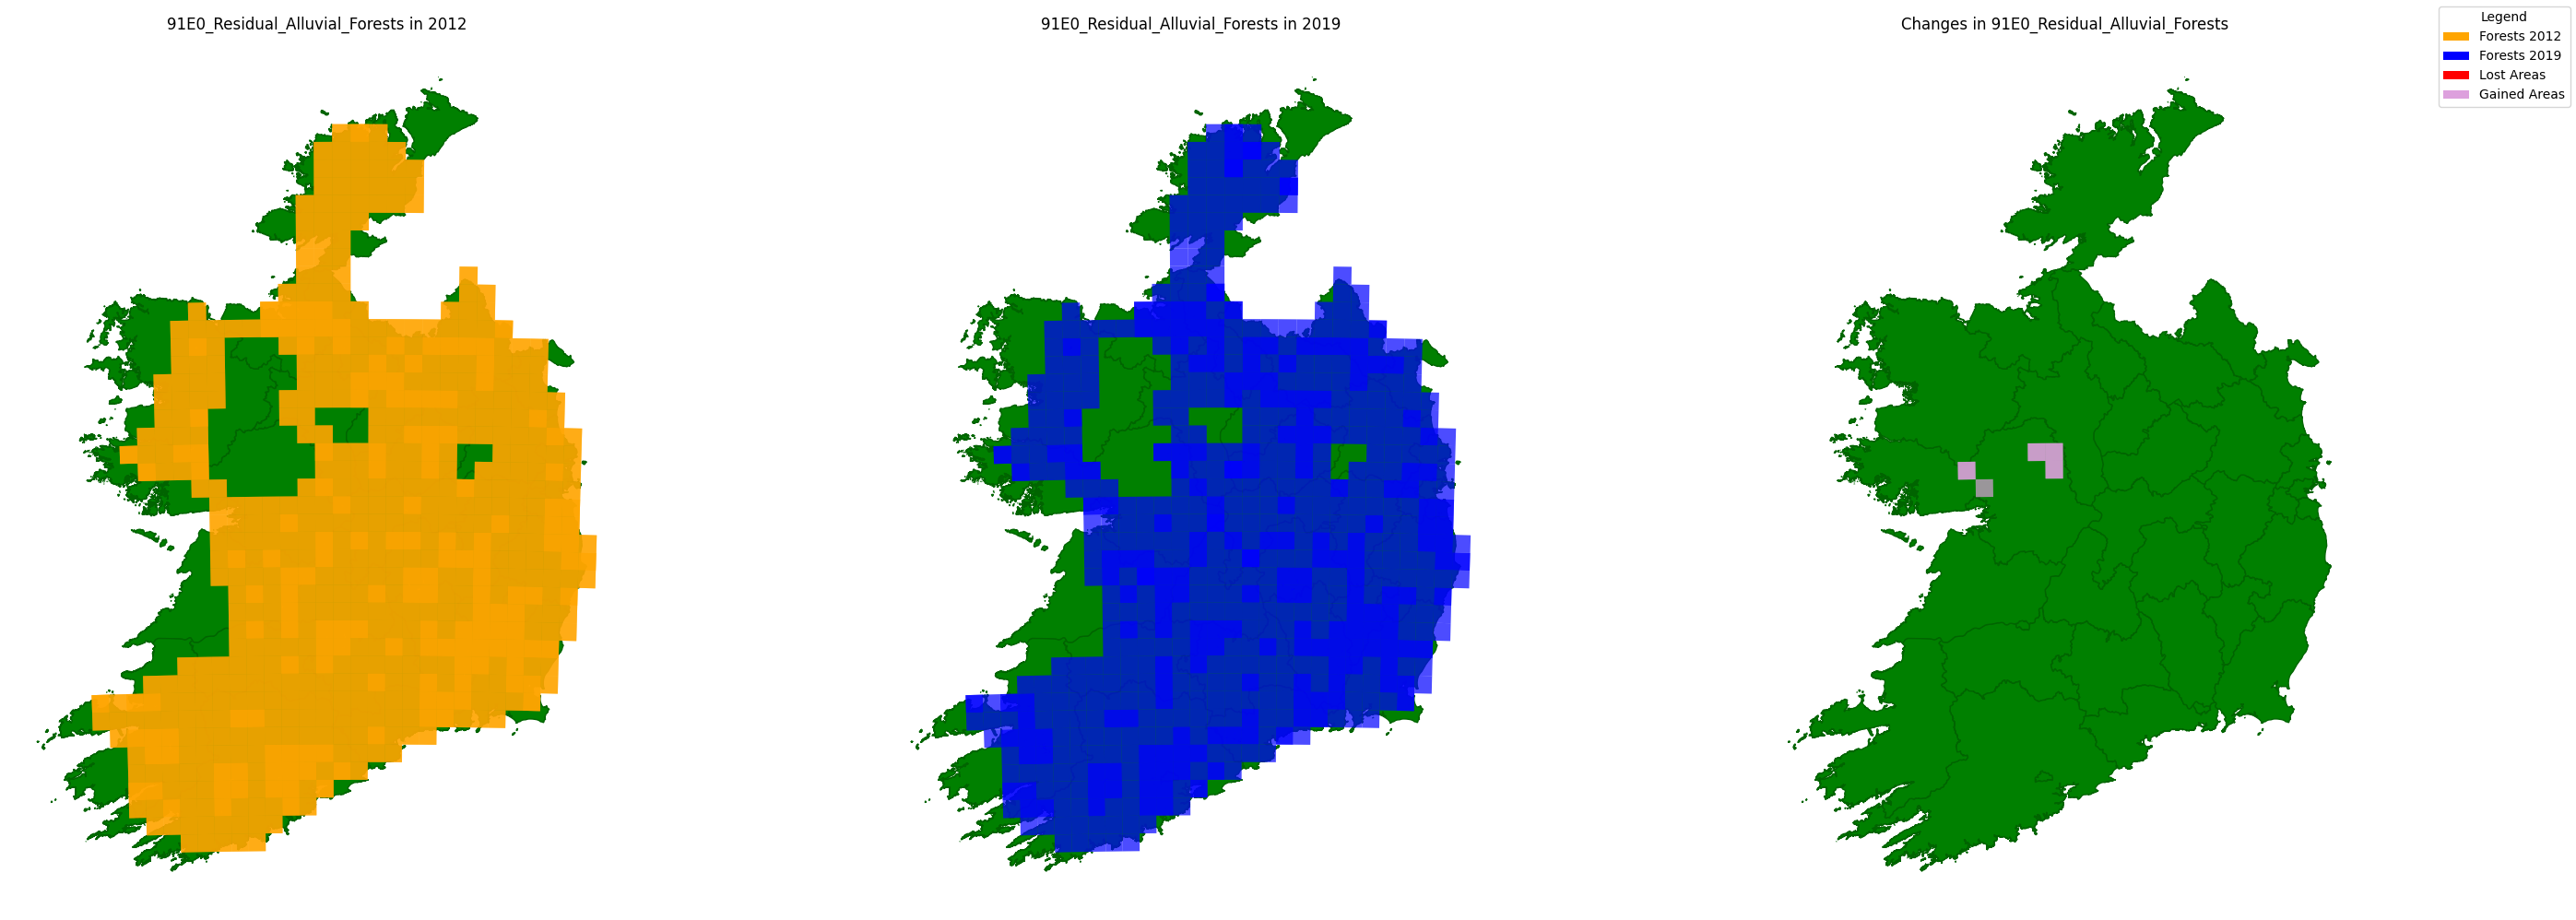

2012 data missing


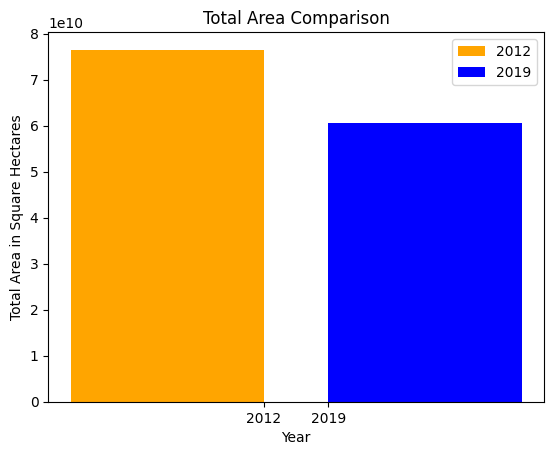

In [ ]:
interactive_habitat_comparison(base_path, 2012, 2019, ireland_map, 'Forests')

# Conclusions

By interacting with the maps and graphs we can visualise the impact Article 17 in conserving natural habitats in Ireland

We can observe that there have been some gains in habitats which can potentially be attributed to the effectiveness of Article 17 but we cannot say for sure if it is solely responsible

There is a need for enhanced protective measures in areas where there is a signifigant loss of populations of natural inhabitants or features

If we can obtain further data in the coming years we will be able to gain further insights into the impact of Article 17 and assess long term sustainability practices

# Limitations

While every care has been taken to ensure the consistency of the data across different years, the Irish data for Article 17 is limited and inconsistent throughout the years

For example no fish data was stored for 2012 so it is not possible to compare the data between the years

Data Columns were also inconsistent between the years which required some pre-processing to fix however some graphs do not have sufficient data and cannot be displayed correctly

